In [1]:
import pickle
import copy
import numpy as np
import g2o
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("..")
from mapper.geometry import from_twist, to_twist

np.random.seed(0)

In [2]:
camera_matrix = pickle.load(open("camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
pose_graph = pickle.load(open("pose_graph.pkl", "rb"))
map_points = pickle.load(open("map_points.pkl", "rb"))

In [3]:
map_points_bak = np.copy(map_points.pts_3d)

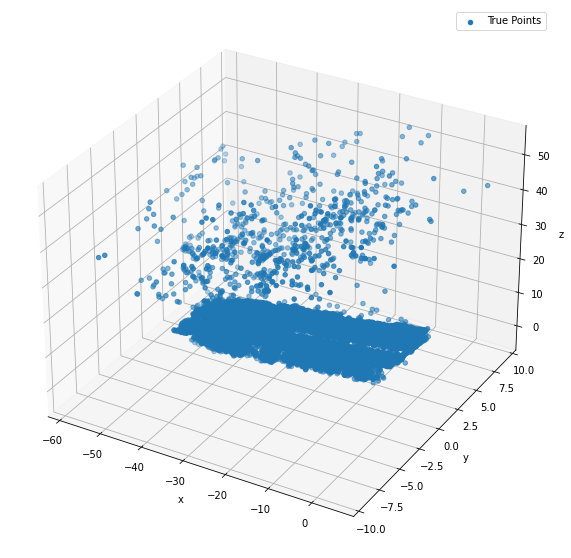

In [4]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(map_points.pts_3d[:, 0], map_points.pts_3d[:, 1], map_points.pts_3d[:, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend(["True Points", "Before Optimization", "After Optimization"])
plt.show()

In [5]:
camera_matrix

array([[1.11981664e+03, 0.00000000e+00, 3.21227846e+02],
       [0.00000000e+00, 1.12392668e+03, 2.65048270e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [6]:
nodes = list(pose_graph.nodes)[:15]
for i, node_id in enumerate(nodes):
    R, t = from_twist(pose_graph.nodes[node_id]["pose"])
    print(R, t)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.]
 [0.]
 [0.]]
[[ 0.9999644   0.00130517  0.00833638]
 [-0.00133224  0.99999385  0.00324276]
 [-0.0083321  -0.00325375  0.99995999]] [[-0.81459149]
 [-0.09094632]
 [-0.57286078]]
[[ 0.99959704  0.00445658  0.02803399]
 [-0.00597572  0.99850455  0.05434118]
 [-0.02774989 -0.05448681  0.99812882]] [[-1.87970367]
 [ 0.0028373 ]
 [-1.31554505]]
[[ 9.99791215e-01 -1.87176649e-03  2.03475330e-02]
 [ 5.23737968e-04  9.97815868e-01  6.60546754e-02]
 [-2.04267302e-02 -6.60302274e-02  9.97608519e-01]] [[-2.86287604]
 [ 0.18941188]
 [-1.54368033]]
[[ 0.99992826 -0.00558123  0.01059788]
 [ 0.00498569  0.99845109  0.05541268]
 [-0.01089074 -0.05535586  0.99840729]] [[-3.84019106]
 [-0.02683128]
 [-1.51789278]]
[[ 0.99981846 -0.00759482  0.01747453]
 [ 0.00697772  0.99935915  0.03510829]
 [-0.01772998 -0.03497998  0.99923073]] [[-5.03112137]
 [-0.06520622]
 [-1.36733379]]
[[ 0.99989445 -0.00699994  0.01273112]
 [ 0.00672159  0.99974027  0.02177663]
 [-0.01288

In [28]:
###################################################################
#
# local bundle adjustment
#
###################################################################

## setup optimizer and camera parameters
robust_kernel = True
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverSE3(g2o.LinearSolverCholmodSE3())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

focal_length = (camera_matrix[0,0] + camera_matrix[1,1]) / 2
principal_point = (camera_matrix[0,2], camera_matrix[1,2])
print("focal_length: ", focal_length, "principal_point: ", principal_point)
cam = g2o.CameraParameters(focal_length, principal_point, 0)
cam.set_id(0)
optimizer.add_parameter(cam)

focal_length:  1121.8716561940905 principal_point:  (321.2278456933972, 265.04827021019815)


True

In [29]:
# add current keyframe poses
true_poses = []
nodes = list(pose_graph.nodes)[:15]
for i, node_id in enumerate(nodes):
    R, t = from_twist(pose_graph.nodes[node_id]["pose"])
    pose = g2o.SE3Quat(R, np.squeeze(t))
    true_poses.append(pose)

    v_se3 = g2o.VertexSE3Expmap()
    v_se3.set_id(i)
    v_se3.set_estimate(pose)
    if i < 2:
        v_se3.set_fixed(True)
    optimizer.add_vertex(v_se3)

# add map points
point_id = len(true_poses)
inliers = dict()
for i, point in enumerate(map_points.pts_3d):    
    visible = []
    for j, pose in enumerate(true_poses):
        z = cam.cam_map(pose * point)
        if 0 <= z[0] < 640 and 0 <= z[1] < 512:
            visible.append((j, z))
            #print(i, j, point, z)
    if len(visible) < 2:
        continue

    vp = g2o.VertexSBAPointXYZ()
    vp.set_id(point_id)
    vp.set_marginalized(True)
    vp.set_estimate(point)
    optimizer.add_vertex(vp)

    for j, z in visible:
        edge = g2o.EdgeProjectXYZ2UV()
        edge.set_vertex(0, vp)
        edge.set_vertex(1, optimizer.vertex(j))
        edge.set_measurement(z)
        edge.set_information(0.1*np.identity(2))
        if robust_kernel:
            #edge.set_robust_kernel(g2o.RobustKernelHuber())
            edge.set_robust_kernel(g2o.RobustKernelHuber(np.sqrt(5.991)))  # 95% CI

        edge.set_parameter_id(0, 0)
        optimizer.add_edge(edge)

    inliers[point_id] = i
    point_id += 1

print('num vertices:', len(optimizer.vertices()))
print('num edges:', len(optimizer.edges()))

num vertices: 930
num edges: 3279


In [30]:
print('Performing full BA:')
optimizer.initialize_optimization()
optimizer.set_verbose(True)
optimizer.optimize(10)

poses_optimized = []
map_points_optimized = np.copy(map_points.pts_3d)

# read out optimized poses
for i in range(len(true_poses)):
    vp = optimizer.vertex(i)
    se3quat = vp.estimate()
    R = np.copy(se3quat.to_homogeneous_matrix()[0:3, 0:3])
    t = np.copy(se3quat.to_homogeneous_matrix()[0:3, 3])
    print(R, t)
    poses_optimized.append(to_twist(R, t))

# read out optimized map points
for i, point_id in enumerate(inliers):
    vp = optimizer.vertex(point_id)
    map_points_optimized[i, :] = np.copy(vp.estimate())    

Performing full BA:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [0. 0. 0.]
[[ 0.9999644   0.00130517  0.00833638]
 [-0.00133224  0.99999385  0.00324276]
 [-0.0083321  -0.00325375  0.99995999]] [-0.81459149 -0.09094632 -0.57286078]
[[ 0.99959704  0.00445658  0.02803399]
 [-0.00597572  0.99850455  0.05434118]
 [-0.02774989 -0.05448681  0.99812882]] [-1.87970367  0.0028373  -1.31554505]
[[ 9.99791215e-01 -1.87176649e-03  2.03475330e-02]
 [ 5.23737968e-04  9.97815868e-01  6.60546754e-02]
 [-2.04267302e-02 -6.60302274e-02  9.97608519e-01]] [-2.86287604  0.18941188 -1.54368033]
[[ 0.99992826 -0.00558123  0.01059788]
 [ 0.00498569  0.99845109  0.05541268]
 [-0.01089074 -0.05535586  0.99840729]] [-3.84019106 -0.02683128 -1.51789278]
[[ 0.99981846 -0.00759482  0.01747453]
 [ 0.00697772  0.99935915  0.03510829]
 [-0.01772998 -0.03497998  0.99923073]] [-5.03112137 -0.06520622 -1.36733379]
[[ 0.99989445 -0.00699994  0.01273112]
 [ 0.00672159  0.99974027  0.02177663]
 [-0.01288025 -0.02168876  0.9996818 ]

In [31]:
np.linalg.norm(map_points_optimized - map_points_bak, axis=0)

array([ 90.33446572,  72.7204791 , 272.04569622])

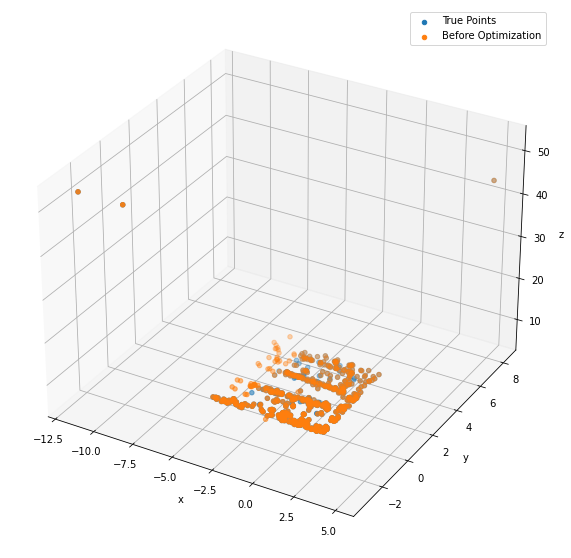

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(map_points_optimized[:500, 0], map_points_optimized[:500, 1], map_points_optimized[:500, 2])
ax.scatter(map_points_bak[:500, 0], map_points_bak[:500, 1], map_points_bak[:500, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend(["True Points", "Before Optimization", "After Optimization"])
plt.show()

In [70]:
import pickle
import numpy as np
import g2o 
from collections import defaultdict

import sys
sys.path.append("..")
from mapper.geometry import from_twist, to_twist

pixel_noise = 1.0  # noise in image pixel space (default: 1.0)
outlier_ratio = 0.0  # probability of spuroius observation  (default: 0.0)
robust_kernel = True  # use robust kernel
#seed = 0

In [71]:
camera_matrix = pickle.load(open("camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
pose_graph = pickle.load(open("pose_graph.pkl", "rb"))
map_points = pickle.load(open("map_points.pkl", "rb"))

In [72]:
np.random.seed(0)

In [73]:
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverSE3(g2o.LinearSolverCholmodSE3())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

focal_length = (camera_matrix[0,0] + camera_matrix[1,1]) / 2
principal_point = (camera_matrix[0,2], camera_matrix[1,2])
print("focal_length: ", focal_length, "principal_point: ", principal_point)
cam = g2o.CameraParameters(focal_length, principal_point, 0)
cam.set_id(0)
optimizer.add_parameter(cam)

true_poses = []
nodes = list(pose_graph.nodes)[:15]
for i, node_id in enumerate(nodes):
    R, t = from_twist(pose_graph.nodes[node_id]["pose"])
    pose = g2o.SE3Quat(R, np.squeeze(t))
    
    true_poses.append(pose)

    v_se3 = g2o.VertexSE3Expmap()
    v_se3.set_id(i)
    v_se3.set_estimate(pose)
    if i < 2:
        v_se3.set_fixed(True)
    optimizer.add_vertex(v_se3)


point_id = len(true_poses)
inliers = dict()
sse = defaultdict(float)
vertices_before_optimization = []

for i, point in enumerate(np.copy(map_points.pts_3d)):
    visible = []
    for j, pose in enumerate(true_poses):
        z = cam.cam_map(pose * point)
        if 0 <= z[0] < 640 and 0 <= z[1] < 512:
            visible.append((j, z))
    if len(visible) < 2:
        continue

    vp = g2o.VertexSBAPointXYZ()
    vp.set_id(point_id)
    vp.set_marginalized(True)
    vp.set_estimate(point)# + np.random.randn(3))
    optimizer.add_vertex(vp)

    inlier = True
    for j, z in visible:
        #z += np.random.randn(2) * pixel_noise

        edge = g2o.EdgeProjectXYZ2UV()
        edge.set_vertex(0, vp)
        edge.set_vertex(1, optimizer.vertex(j))
        edge.set_measurement(z)
        edge.set_information(np.identity(2))
        if robust_kernel:
            edge.set_robust_kernel(g2o.RobustKernelHuber())
            #edge.set_robust_kernel(g2o.RobustKernelHuber(np.sqrt(5.991)))  # 95% CI

        edge.set_parameter_id(0, 0)
        optimizer.add_edge(edge)


    inliers[point_id] = i
    vertices_before_optimization.append(np.copy(vp.estimate()))
    point_id += 1

focal_length:  1121.8716561940905 principal_point:  (321.2278456933972, 265.04827021019815)


In [74]:
print('num vertices:', len(optimizer.vertices()))
print('num edges:', len(optimizer.edges()))

num vertices: 930
num edges: 3279


In [75]:
print('Performing full BA:')
optimizer.initialize_optimization()
optimizer.set_verbose(True)
optimizer.optimize(10)

vertices_after_optimization = []
for i in inliers:
    vp = optimizer.vertex(i)
    vertices_after_optimization.append(np.copy(vp.estimate()))
    
vertices_before_optimization = np.stack(vertices_before_optimization)
vertices_after_optimization = np.stack(vertices_after_optimization)

Performing full BA:


In [76]:
for pose in true_poses:
    R = np.copy(pose.to_homogeneous_matrix()[0:3, 0:3])
    t = np.copy(pose.to_homogeneous_matrix()[0:3, 3])
    print(R, t)
    
for i in range(len(true_poses)):
    vp = optimizer.vertex(i)
    se3quat = vp.estimate()
    R = np.copy(se3quat.to_homogeneous_matrix()[0:3, 0:3])
    t = np.copy(se3quat.to_homogeneous_matrix()[0:3, 3])
    print(R, t)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [0. 0. 0.]
[[ 0.9999644   0.00130517  0.00833638]
 [-0.00133224  0.99999385  0.00324276]
 [-0.0083321  -0.00325375  0.99995999]] [-0.81459149 -0.09094632 -0.57286078]
[[ 0.99959704  0.00445658  0.02803399]
 [-0.00597572  0.99850455  0.05434118]
 [-0.02774989 -0.05448681  0.99812882]] [-1.87970367  0.0028373  -1.31554505]
[[ 9.99791215e-01 -1.87176649e-03  2.03475330e-02]
 [ 5.23737968e-04  9.97815868e-01  6.60546754e-02]
 [-2.04267302e-02 -6.60302274e-02  9.97608519e-01]] [-2.86287604  0.18941188 -1.54368033]
[[ 0.99992826 -0.00558123  0.01059788]
 [ 0.00498569  0.99845109  0.05541268]
 [-0.01089074 -0.05535586  0.99840729]] [-3.84019106 -0.02683128 -1.51789278]
[[ 0.99981846 -0.00759482  0.01747453]
 [ 0.00697772  0.99935915  0.03510829]
 [-0.01772998 -0.03497998  0.99923073]] [-5.03112137 -0.06520622 -1.36733379]
[[ 0.99989445 -0.00699994  0.01273112]
 [ 0.00672159  0.99974027  0.02177663]
 [-0.01288025 -0.02168876  0.9996818 ]] [-6.06232202 -0.06